# Análisis de sentimientos en reviews de películas
El objetivo de este proyecto es trabajar con un dataset de reviews de películas y clasificar cada comentario de acuerdo al sentimiento positivo o negativo expresado hacia la película. Para hacerlo, se trabajará con procesamiento de texto para luego aplicar diferentes técnicas predictivas.

En este caso no se trabajará con un archivo '.csv', sino con un directorio estructurado de la siguiente forma: 
```
movie_reviews/
  neg/
  pos/
```
Para cargar las opiniones y poder comenzar a procesarlas, Sickit-learn provee la función 'load_files' que permite recorrer este tipo de estructuras. 

In [1]:
import warnings
warnings.filterwarnings("ignore")
import sklearn
from sklearn.datasets import load_files
moviedir = r'./dataset/movie_reviews' 
movie_reviews = load_files(moviedir, shuffle=True)

En la variable 'movie_reviews' se guardarán reviews ('movie_reviews.data') y su sentimiento ('movie_reviews.target').
El total de reviews con las que se trabajará es:

In [2]:
print("Tenemos {} reviews, con clases {},".format(len(movie_reviews.data), movie_reviews.target_names))

Tenemos 2000 reviews, con clases ['neg', 'pos'],


La estructura de los datos, se puede observar en la siguiente muestra de 'movie_reviews.data':

In [3]:
movie_reviews.data[0][:500]

b"arnold schwarzenegger has been an icon for action enthusiasts , since the late 80's , but lately his films have been very sloppy and the one-liners are getting worse . \nit's hard seeing arnold as mr . freeze in batman and robin , especially when he says tons of ice jokes , but hey he got 15 million , what's it matter to him ? \nonce again arnold has signed to do another expensive blockbuster , that can't compare with the likes of the terminator series , true lies and even eraser . \nin this so cal"

Y la categoría asociada a esta opinion se puede ver con la propiedad 'target' de movie_reviews:

In [4]:
movie_reviews.target[0]

0

En este caso es un 0, es decir que el sentimiento expresado es negativo 'neg'. Por otro lado, si el resultado fuera un 1, el sentimiento asociado sería positivo 'pos'.

## Conjuntos de entrenamiento y de testeo
Se crea un dataframe con Pandas con los datos de 'movie_reviews.data':

In [5]:
import pandas as pd
movie_reviews.data = pd.DataFrame(movie_reviews.data,dtype="str")
movie_reviews.data.head()

,0
0,arnold schwarzenegger has been an icon for act...
1,good films are hard to find these days . \ngre...
2,quaid stars as a man who has taken up the prof...
3,we could paraphrase michelle pfieffer's charac...
4,kolya is one of the richest films i've seen in...


Para iniciar con el entrenamiento y probar distintos algoritmos con el fin de encontrar los mejores modelos, se separa el conjunto de reviews en training y testing.

In [6]:
movie_reviews.data = [str(i) for i in movie_reviews.data.values]

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    movie_reviews.data, movie_reviews.target, test_size = 0.20, 
    stratify=movie_reviews.target, random_state = 12)

## Preprocesamiento de los datos
Para trabajar con cadenas de texto se debe realizar una serie de pasos antes de entrenar un modelo. Es decir, se convertirá el texto a una representación numérica, capaz de ser interpretada por los algoritmos de clasificación. 
Para esto se realizarán los siguientes pasos:
- Tokenizar el texto
- Convertir a vectores de términos/documentos
- Aplicar tf_idf

**Nota:** El 'fit' debe hacerse sobre el conjunto de train y no sobre el total, ya que 'tf_idf' tiene en cuenta la frecuencia de aparición de las palabras respecto al total del conjunto. Después de usar 'fit' con el conjunto de entrenamiento se puede aplicar la transformación al conjunto de test. 

Se vectorizan los textos para obtener una matriz de términos/documentos utilizando td-idf: 

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf = TfidfVectorizer()
X_train = tf_idf.fit_transform(X_train)
X_test = tf_idf.transform(X_test)

### Dimensión de la matriz de términos
Una vez vectorizados los documentos se observa la forma que tiene la matriz resultante.

In [9]:
X_train.shape

(1600, 40635)

La gran dimensión de la matriz responde a: 

* 1.600 filas: pues fue creada con el 80% de las reviews, es decir el conjunto de entrenamiento.
* 40.635 columnas: es el número presente de términos en el dataset. Como hasta el momento no se ha realizado ningún tipo de filtrado,cada columna corresponde a un término existente.

## Entrenamiento de modelos
A partir de la matriz creada con los vectores y luego de aplicar td-idf, se comenzará con el proceso de entrenamiento de los algoritmos. Serán comparados los siguientes modelos:
- SVM 
- Multilayer Perceptron
- Random Forest 
- AdaBoost 
- Voting 

Para el entrenamiento de cada uno se utilizará GridSearch, recorriendo una lista de parámetros según cada algoritmo. También se usará 5-fold CV y el scoring estará dado por el área bajo la curva roc.

### 1. Support Vector Machines (SVM)
En este primer modelo, se ajustará un SVM al conjunto de datos de entrenamiento y se devolverá la matriz de confusión en testing. Al tener menos instancias que features, el procedimiento recomendado es utilizar un kernel lineal (información basada en el paper https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf). 

El espacio de parámetros utilizado para GridSearch será:

* C = [0.001, 0.01, 0.1, 1, 10]
* loss = ['hinge', 'squared_hinge'] 

Entonces se utilizará Grid Search y el clasificador LinearSVC, con 5-fold para el cross validation y el área bajo la curva roc como scoring.

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10], "loss":['hinge', 'squared_hinge']}
lsvc = LinearSVC()
grid_search = GridSearchCV(lsvc, param_grid, cv=5, scoring='roc_auc', return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LinearSVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'loss': ['hinge', 'squared_hinge']},
             return_train_score=True, scoring='roc_auc')

Estos son los resultados promediados por cada combinación de parámetros:

In [11]:
grid_search.cv_results_['mean_train_score']

array([0.9569043 , 0.95863965, 0.9569043 , 0.96610352, 0.95703027,
       0.99436621, 0.99979883, 1.        , 1.        , 1.        ])

Esta es la combinación mas eficaz de parámetros:

In [12]:
grid_search.best_params_

{'C': 1, 'loss': 'squared_hinge'}

Se guarda el mejor algoritmo para este clasificador:

In [13]:
optimised_svm = grid_search.best_estimator_

## Matriz de confusión 
La matríz de confusión, permite visualizar fácilmente el resultado de un clasificador.
A continuación se realiza una función para crear una matriz de confusión utilizando 'matplotlib'.

In [14]:
import numpy as np
import itertools
import matplotlib.pylab as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Esta función imprime y grafica la matriz de confusión. Para normalizarla
    se puede ajustar el parámetro 'normalize=True'.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [15]:
target = movie_reviews.target_names
print(target)

['neg', 'pos']


Se aplica la matriz de confusión para los resultados de la predicción del clasificador LinearSVC sobre el conjunto de test:

El score es:  0.8525
Confusion matrix, without normalization
[[168  32]
 [ 27 173]]


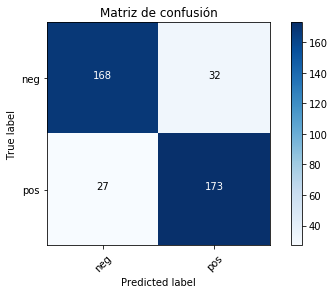

Normalized confusion matrix
[[0.84  0.16 ]
 [0.135 0.865]]


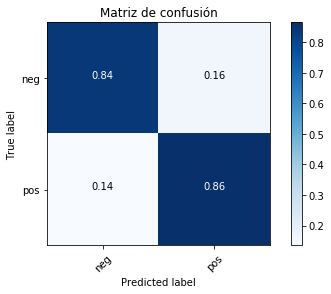

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pylab as plt
y_predt = grid_search.predict(X_test)
print('El score es: ', accuracy_score(y_test, y_predt))

c_matrix = confusion_matrix(y_test, y_predt)
plt.figure()
plot_confusion_matrix(c_matrix, classes=target,
                      title='Matriz de confusión')
plot_confusion_matrix(c_matrix, classes=target, normalize=True,
                      title='Matriz de confusión')

Se importan métricas desde Sickit-learn para calcular el área bajo la curva ROC (AUC) en el conjunto de testeo y se muestra el 'classification_report':

In [17]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test, y_predt))

from sklearn.metrics import classification_report
print(classification_report(y_test, y_predt))

0.8525
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       200
           1       0.84      0.86      0.85       200

    accuracy                           0.85       400
   macro avg       0.85      0.85      0.85       400
weighted avg       0.85      0.85      0.85       400



### 2. Random Forests
Para este modelo se tendrá en cuenta el siguiente espacio de búsqueda:

* n_estimators = [100, 500, 1000]
* max_depth: [3, 7, None]
* min_samples_split: [2, 3, 10]
* bootstrap: [True, False]
* criterion: ["gini", "entropy"]

y se usará Grid Search con 5-fold para el cross validation y el área bajo la curva roc como scoring.

In [18]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
param_grid = {'n_estimators': [100, 500, 1000], "max_depth":[3, 7, None],
              "min_samples_split": [2, 3, 10], "bootstrap": [True, False], 
              "criterion": ["gini", "entropy"]  }
grid_search = GridSearchCV(rfc, param_grid, cv=5, n_jobs=-1, verbose=True, 
                           scoring='roc_auc', return_train_score=True)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 23.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 63.4min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 87.2min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 7, None],
                         'min_samples_split': [2, 3, 10],
                         'n_estimators': [100, 500, 1000]},
             return_train_score=True, scoring='roc_auc', verbose=True)

Se repite el procedimiento utilizado en el modelo anterior para la técnica de Random Forest: 

El score es:  0.825
Confusion matrix, without normalization
[[171  29]
 [ 41 159]]


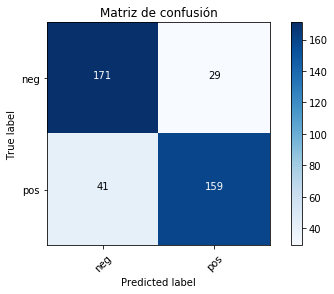

Normalized confusion matrix
[[0.855 0.145]
 [0.205 0.795]]


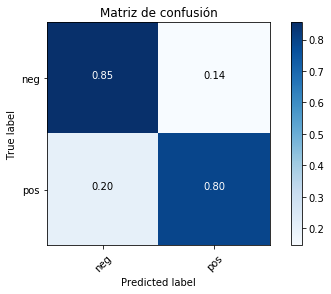

In [19]:
y_predt = grid_search.predict(X_test)
print('El score es: ', accuracy_score(y_test, y_predt))
c_matrix = confusion_matrix(y_test, y_predt)

plt.figure()
plot_confusion_matrix(c_matrix, classes=target,
                      title='Matriz de confusión')
plot_confusion_matrix(c_matrix, classes=target, normalize=True,
                      title='Matriz de confusión')

In [20]:
grid_search.best_params_

{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': None,
 'min_samples_split': 10,
 'n_estimators': 1000}

In [21]:
optimised_rdf = grid_search.best_estimator_

In [22]:
print(roc_auc_score(y_test, y_predt))
print(classification_report(y_test, y_predt))

0.825
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       200
           1       0.85      0.80      0.82       200

    accuracy                           0.82       400
   macro avg       0.83      0.82      0.82       400
weighted avg       0.83      0.82      0.82       400



### 3. Multilayer Perceptron
Para este modelo se aplicará el mismo proceso, teniendo en cuenta un espacio de búsqueda definido por los siguientes valores de 'param_grid': 
- {'hidden_layer_sizes': [(10,),(5,5), (2,2)]}

In [23]:
from sklearn.neural_network import MLPClassifier
param_grid = {'hidden_layer_sizes': [(10,), (5,5), (2,2)]}
mlp = MLPClassifier()
grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='roc_auc', return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=MLPClassifier(),
             param_grid={'hidden_layer_sizes': [(10,), (5, 5), (2, 2)]},
             return_train_score=True, scoring='roc_auc')

El score es:  0.855
Confusion matrix, without normalization
[[163  37]
 [ 21 179]]


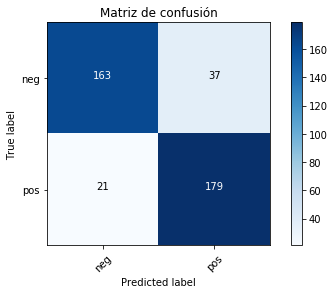

Normalized confusion matrix
[[0.815 0.185]
 [0.105 0.895]]


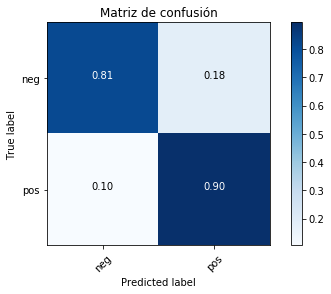

In [24]:
y_predt = grid_search.predict(X_test)
print('El score es: ', accuracy_score(y_test, y_predt))
c_matrix = confusion_matrix(y_test, y_predt)
plt.figure()
plot_confusion_matrix(c_matrix, classes=target,
                      title='Matriz de confusión')
plot_confusion_matrix(c_matrix, classes=target, normalize=True,
                      title='Matriz de confusión')

In [25]:
grid_search.best_params_

{'hidden_layer_sizes': (10,)}

In [26]:
optimised_mlp = grid_search.best_estimator_

In [27]:
print(roc_auc_score(y_test, y_predt))
print(classification_report(y_test, y_predt))

0.855
              precision    recall  f1-score   support

           0       0.89      0.81      0.85       200
           1       0.83      0.90      0.86       200

    accuracy                           0.85       400
   macro avg       0.86      0.85      0.85       400
weighted avg       0.86      0.85      0.85       400



### 4. AdaBoost
Para el modelo AdaBoost, el 'param_grid' recorrerá estos valores: 
- {'n_estimators': [50, 100, 500]}

Se repetirá el proceso completo.


In [28]:
from sklearn.ensemble import AdaBoostClassifier
param_grid = {'n_estimators': [50, 100, 500]}
ada = AdaBoostClassifier()
grid_search = GridSearchCV(ada, param_grid, cv=5, scoring='roc_auc', return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=AdaBoostClassifier(),
             param_grid={'n_estimators': [50, 100, 500]},
             return_train_score=True, scoring='roc_auc')

El score es:  0.8275
Confusion matrix, without normalization
[[162  38]
 [ 31 169]]


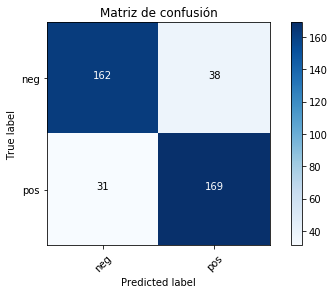

Normalized confusion matrix
[[0.81  0.19 ]
 [0.155 0.845]]


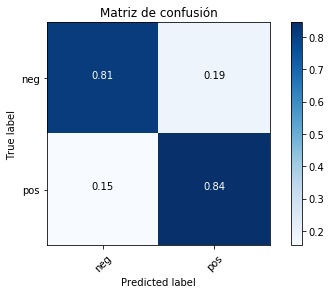

In [29]:
y_predt = grid_search.predict(X_test)
print('El score es: ', accuracy_score(y_test, y_predt))
c_matrix = confusion_matrix(y_test, y_predt)
plt.figure()
plot_confusion_matrix(c_matrix, classes=target,
                      title='Matriz de confusión')
plot_confusion_matrix(c_matrix, classes=target, normalize=True,
                      title='Matriz de confusión')

In [30]:
grid_search.best_params_

{'n_estimators': 500}

In [31]:
optimised_ada = grid_search.best_estimator_

In [32]:
print(roc_auc_score(y_test, y_predt))
print(classification_report(y_test, y_predt))

0.8275
              precision    recall  f1-score   support

           0       0.84      0.81      0.82       200
           1       0.82      0.84      0.83       200

    accuracy                           0.83       400
   macro avg       0.83      0.83      0.83       400
weighted avg       0.83      0.83      0.83       400



### 5. Voting
A partir de los resultados obtenidos, se armará un ensamble entre los cuatro modelos utilizados usando votación y se medirá el accuracy de cada uno de estos.

In [33]:
from sklearn.ensemble import VotingClassifier 
svc_clf = optimised_svm
rdf_clf = optimised_rdf
mlp_clf = optimised_mlp
ada_clf = optimised_ada

voting_clf = VotingClassifier(estimators=[('svc', svc_clf), ('rdf', rdf_clf), 
                                          ("mlp", mlp_clf), ("ada", ada_clf)],voting='hard')

for clf in (svc_clf, rdf_clf, mlp_clf, ada_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LinearSVC 0.8525
RandomForestClassifier 0.825
MLPClassifier 0.855
AdaBoostClassifier 0.8275
VotingClassifier 0.8675


En este caso se seleccionará VotingClassifier como modelo final, pues es el que tiene mejor score. Se entrenará de nuevo con todos los datos del conjunto 'train'.

In [34]:
tf_idf = TfidfVectorizer()
movie_reviews.data = tf_idf.fit_transform(movie_reviews.data)

In [35]:
eclf = voting_clf
eclf.fit(movie_reviews.data, movie_reviews.target)

VotingClassifier(estimators=[('svc', LinearSVC(C=1)),
                             ('rdf',
                              RandomForestClassifier(bootstrap=False,
                                                     criterion='entropy',
                                                     min_samples_split=10,
                                                     n_estimators=1000)),
                             ('mlp', MLPClassifier(hidden_layer_sizes=(10,))),
                             ('ada', AdaBoostClassifier(n_estimators=500))])

In [36]:
movie_reviews.data.shape

(2000, 44519)

In [37]:
import joblib
joblib.dump(eclf, 'sentiment.pkl') 

['sentiment.pkl']

In [38]:
y_pred

array([0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1,

## Aplicación del mejor modelo de clasificación encontrado
Se utilizarán las críticas de la película Rocky 4 para probar el modelo.

In [39]:
reviews_new = ["Stallone creates credible villains worthy of his heroic character.",
               "Another brilliant Rocky film, probably my favourite one out of the lot",
               "Yeah, this movie sucks.",
               "My favourite rocky film! So good so much heart. Slightly better than 2",
               "What has this got to do with boxing. Also everyone looked like dolls. Also if you are a real true boxing fan (not casuals), you would understand that this stupidity is no description of boxing!!",
               "The new film's narrative is stripped down to essentials, which gives it an emblematic quality.",
               "Absurdly ridiculous, this just isn't a good movie at all", 
               "Very basic and predictable but still an okay movie. No special music to save this one.", 
              "Rocky 4 is an extremely ambitious movie that is definitely worth watching.",
              'Highly beautiful',
               "If it wasn't for the robots (WTF????), and the painfully overwritten lines of an absurdly dogmatic persuasion, then this would otherwise be nothing more than an interminable series of mildly rousing montages. There are some unintentionally funny bits though, and Dolph's Ivan showcases the best and worst of all Rocky's opponents.",
              "While all aspects of realism is thrown out the window, ROCKY IV is an adrenaline rush of action and excitment, with an incredible soundtrack and arguably the best movie fight in history between Balboa and Drago",
              "Just like the songs, exercise routines and repetitive clips, it seems redundant to add another installment in this already falling franchise when you clearly lack material. Rocky IV is petty, childish and seems overlong despite of its 91 minutes of run time for it merely has an idea of a TV drama episode which is stretched to a point of exhaustion. Its painful to watch Sylvester Stallone go through this enormous amount of training and hardly make a point out there. He fails on all the levels here; writer, director and actor, to deliver any loose end of the thread for the audience to hang on to. Rocky IV is predictable, loosely written and choreographed and executed unsupervised."]
reviews_new_counts = tf_idf.transform(reviews_new)
reviews_new_tfidf = tf_idf.transform(reviews_new)

In [40]:
reviews_new_tfidf.shape

(13, 44519)

In [41]:
pred = eclf.predict(reviews_new_tfidf)

In [42]:
for review, category in zip(reviews_new, pred):
    print('%r => %s \n' % (review, movie_reviews.target_names[category]))

'Stallone creates credible villains worthy of his heroic character.' => pos 

'Another brilliant Rocky film, probably my favourite one out of the lot' => pos 

'Yeah, this movie sucks.' => neg 

'My favourite rocky film! So good so much heart. Slightly better than 2' => pos 

'What has this got to do with boxing. Also everyone looked like dolls. Also if you are a real true boxing fan (not casuals), you would understand that this stupidity is no description of boxing!!' => neg 

"The new film's narrative is stripped down to essentials, which gives it an emblematic quality." => pos 

"Absurdly ridiculous, this just isn't a good movie at all" => neg 

'Very basic and predictable but still an okay movie. No special music to save this one.' => neg 

'Rocky 4 is an extremely ambitious movie that is definitely worth watching.' => pos 

'Highly beautiful' => pos 

"If it wasn't for the robots (WTF????), and the painfully overwritten lines of an absurdly dogmatic persuasion, then this would oth